In [ ]:
#default_exp swav

# SwAV

> Unsupervised Learning of Visual Features by Contrasting Cluster Assignments

Paper Link: https://arxiv.org/pdf/2006.09882.pdf

In [ ]:
#export
from fastai.vision.all import *
import kornia

## Data Augmentation

In [ ]:
#export
def get_aug_pipe(size, min_scale=0.2, max_scale=1., stats=imagenet_stats, s=.6,
                 color=True, xtra_tfms=[]):
    "SimCLR augmentations"
    tfms = []
    tfms += [kornia.augmentation.RandomResizedCrop((size, size),
                                                   scale=(min_scale, max_scale),
                                                   ratio=(3/4, 4/3))]
    tfms += [kornia.augmentation.RandomHorizontalFlip()]
    
    if color: tfms += [kornia.augmentation.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)]
    if color: tfms += [kornia.augmentation.RandomGrayscale(p=0.2)]    
    if stats is not None: tfms += [Normalize.from_stats(*stats)]
    
    tfms += xtra_tfms
    
    pipe = Pipeline(tfms)
    pipe.split_idx = 0
    return pipe

This creates a data augmentation `Pipeline`. Define `size` for random resized crop, choose whether to use color transforms with `color` boolean and optionally pass your own custom transforms with `xtra_tfms`. Here, `min_scale` and `max_scale` parameters are also exposed to allow multi crop augmentation defined in paper

In [ ]:
#hide
img = PILImage(PILImage.create(TEST_IMAGE).resize((600,400)))
t = Pipeline([ToTensor(), IntToFloatTensor(), Resize(256)])(img)
type(img), type(t)

(fastai.vision.core.PILImage, fastai.torch_core.TensorImage)

In [ ]:
#hide
aug = get_aug_pipe(224)
x = aug(t)
assert x.shape[-2:] == torch.Size([224,224])

Default SimCLR augmentations side by side with the original image

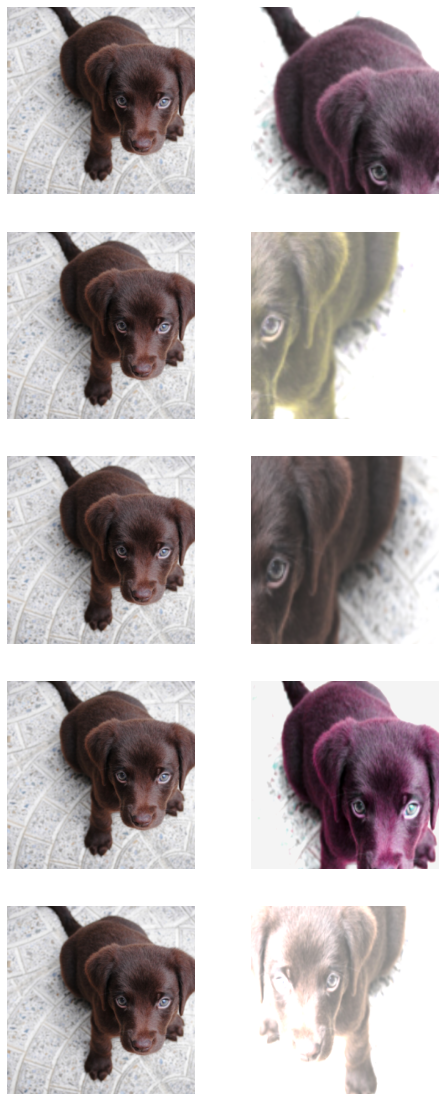

In [ ]:
aug = get_aug_pipe(224)
n = 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n):
    show_image(t,ax=ax[i][0])
    show_image(aug.decode(aug(t)).clamp(0,1)[0], ax=ax[i][1])

Default SimCLR augmentations with extra transforms passed by user side by side with the original image

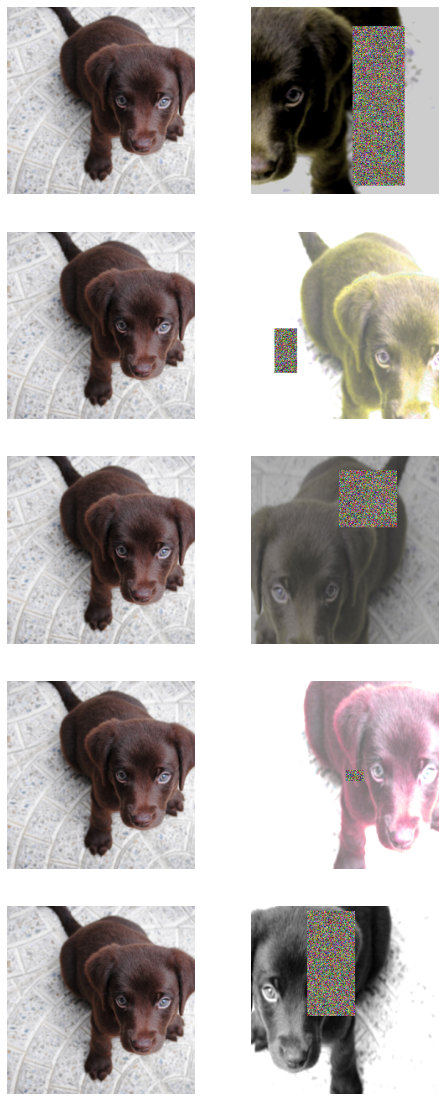

In [ ]:
aug = get_aug_pipe(224, xtra_tfms=[RandomErasing(p=1.)])
n = 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n):
    show_image(t,ax=ax[i][0])
    show_image(aug.decode(aug(t)).clamp(0,1)[0], ax=ax[i][1])

## Architecture

![](images/swav.png)

In [ ]:
#export
def create_encoder(arch, n_in=3, pretrained=True, cut=None, concat_pool=True):
    "Create encoder from a given arch backbone"
    encoder = create_body(arch, n_in, pretrained, cut)
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    return nn.Sequential(*encoder, pool, Flatten())

This function creates an encoder which essentially outputs the embeddings/representations we learn through self-supervised training. It uses `create_body` function from fastai, you can pass any `arch` that is supported, specify number of input channels with `n_in`, optionally load `pretrained` weights if available and or use `concat_pool`. Instead of directly using this function you will most likely call `create_swav_model` when creating your model.

In [ ]:
encoder = create_encoder(xresnet18, n_in=3, pretrained=False, concat_pool=True)
encoder[-2:]

Sequential(
  (8): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (9): Flatten(full=False)
)

In [ ]:
#export
class MLP(Module):
    "MLP module as described in paper"
    def __init__(self, dim, projection_size=256, hidden_size=2048):
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, projection_size)
        )

    def forward(self, x):
        return self.net(x)

This `MLP` module is same with the one implemented for BYOL

In [ ]:
#export
class SwAVModel(Module):
    "SwAV model"
    def __init__(self,encoder,projector,prototypes): 
        self.encoder,self.projector,self.prototypes = encoder,projector,prototypes
    
    def forward(self, inputs): 
        
        if not isinstance(inputs, list): inputs = [inputs]
            
        crop_idxs = torch.cumsum(torch.unique_consecutive(
                                torch.tensor([inp.shape[-1] for inp in inputs]),
                                return_counts=True)[1], 0)

        start_idx = 0
        for idx in crop_idxs:
            _z = self.encoder(torch.cat(inputs[start_idx: idx]))
            if not start_idx: z = _z
            else:             z = torch.cat((z, _z))
            start_idx = idx
        
        z = F.normalize(self.projector(z))
        return z, self.prototypes(z)

In [ ]:
#export
def create_swav_model(arch=resnet50, n_in=3, pretrained=True, cut=None, concat_pool=True,
                      hidden_size=256, projection_size=128, n_protos=3000):
    "Create SwAV from a given arch"
    encoder = create_encoder(arch, n_in, pretrained, cut, concat_pool)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = MLP(representation.size(1), projection_size, hidden_size=hidden_size)  
    prototypes = nn.Linear(projection_size, n_protos, bias=False)
    apply_init(projector)
    with torch.no_grad():
        w = prototypes.weight.data.clone()
        prototypes.weight.copy_(F.normalize(w))
    return SwAVModel(encoder, projector, prototypes)

This function creates a `SwAVModel` with specified arguments. It uses `create_encoder` which is defined earlier. You can also define `hidden_size` for the `MLP` module and the `projection_size`. `n_protos` is used to define the dimension of the prototypes as described in paper

In [ ]:
#hide
inputs = ([torch.randn(2,3,224,224) for i in range(2)] +
          [torch.randn(2,3,96,96) for i in range(4)] )
model = create_swav_model()
embedding, output = model(inputs)
norms = model.prototypes.weight.data.norm(dim=1)
assert norms.shape[0] == 3000
assert [n.item() for n in norms if test_close(n.item(), 1.)] == []

## SwAV Callback

In [ ]:
#export
def sinkhorn_knopp(Q, nmb_iters):
    "https://en.wikipedia.org/wiki/Sinkhorn%27s_theorem#Sinkhorn-Knopp_algorithm"
    with torch.no_grad():
        sum_Q = torch.sum(Q)
        Q /= sum_Q

        r = torch.ones(Q.shape[0]) / Q.shape[0]
        c = torch.ones(Q.shape[1]) / Q.shape[1]

        curr_sum = torch.sum(Q, dim=1)

        for it in range(nmb_iters):
            u = curr_sum
            Q *= (r / u).unsqueeze(1)
            Q *= (c / torch.sum(Q, dim=0)).unsqueeze(0)
            curr_sum = torch.sum(Q, dim=1)
        return (Q / torch.sum(Q, dim=0, keepdim=True)).t().float()

In [ ]:
#export
class SWAVLoss(Module):
    "Multi crop loss"
    def __init__(self): pass     
    def forward(self,log_ps,qs):
        loss = 0
        for i in range(len(qs)):
            l = 0
            q = qs[i]
            for p in (log_ps[:i] + log_ps[i+1:]):
                l -= torch.mean(torch.sum(q*p, dim=1))/(len(log_ps)-1)
            loss += l/len(qs)
        return loss

This loss function calculates multi crop cross entropy loss between original views and low resolution views of the same image. Total `N(V+1)` comparisions are made for a given image, where `N` is the number of original views and `V` is the number of low resolution views

In [ ]:
#export
class SWAV(Callback):
    "SwAV callback"
    def __init__(self, crop_sizes=[224,96], 
                       num_crops=[2,6],
                       min_scales=[0.25,0.05],
                       max_scales=[1.,0.14],
                       crop_assgn_ids=[0,1],
                       eps=0.05,
                       n_sinkh_iter=3,
                       temp=0.1,
                 **aug_kwargs):
        
        store_attr('num_crops,crop_assgn_ids,temp,eps,n_sinkh_iter')
        self.augs = []
        for nc, size, mins, maxs in zip(num_crops, crop_sizes, min_scales, max_scales):
            self.augs += [get_aug_pipe(size, mins, maxs, **aug_kwargs) for i in range(nc)]
                             
    
    def before_batch(self):
        "Compute multi crop inputs"
        self.bs = self.x.size(0)
        self.learn.xb = ([aug(self.x) for aug in self.augs],)
        

    def after_pred(self):
        "Compute ps and qs"    
        embedding, output = self.pred
        with torch.no_grad():
            qs = []
            for i in self.crop_assgn_ids:
                # TODO: Store previous batch embeddings
                # to be used in Q calculation
                # Store approx num_proto//bs batches 
                # output.size(1)//self.bs
                target_b = output[self.bs*i:self.bs*(i+1)]
                q = torch.exp(target_b/self.eps).t()
                q = sinkhorn_knopp(q, self.n_sinkh_iter)
                qs.append(q)
        
        log_ps = []
        for v in np.arange(np.sum(self.num_crops)):
            log_p = F.log_softmax(output[self.bs*v:self.bs*(v+1)] / self.temp, dim=1)
            log_ps.append(log_p)
                           
        self.learn.pred, self.learn.yb = log_ps, (qs,)
    
    
    def after_batch(self):
        with torch.no_grad():
            w = self.learn.model.prototypes.weight.data.clone()
            self.learn.model.prototypes.weight.data.copy_(F.normalize(w))
        
        
    def show_one(self):
        xb = self.learn.xb[0]
        i = np.random.choice(self.bs)
        images = [aug.decode(b.to('cpu').clone()).clamp(0.1)[i] 
                      for b, aug in zip(xb, self.augs)]
        show_images(images)

`crop_sizes` defines the size to be used for original crops and low resolution crops respectively. `num_crops` define `N`: number of original views and `V`: number of low resolution views respectively. `min_scales` and `max_scales` are used for original and low resolution views during random resized crop. `eps` is used during Sinkhorn-Knopp algorithm for calculating the codes and `n_sinkh_iter` is the number of iterations during it's calculation. `temp` is the temperature parameter in cross entropy loss

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=2, after_item=[ToTensor(), IntToFloatTensor()])

In [ ]:
model = create_swav_model(arch=resnet18, n_in=1, pretrained=False)
learn = Learner(dls, model, SWAVLoss(),
                cbs=[SWAV(crop_sizes=[28,16], max_scales=[1.0,0.3],
                          color=False, stats=None),
                     ShortEpochCallback(0.001)])

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.pred = learn.model(*learn.xb)

Display 2 standard resolution crops and 6 additional low resolution crops, aka multi crop

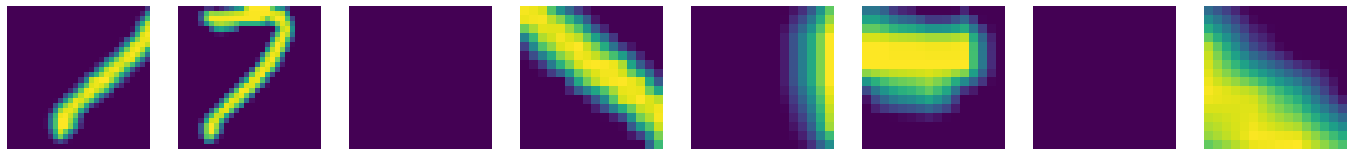

In [ ]:
learn.swav.show_one()

In [ ]:
learn.fit(1)

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 10-simclr.ipynb.
Converted 20-byol.ipynb.
Converted 30-swav.ipynb.
Converted index.ipynb.
